# Instalação das bibliotecas necessárias

In [1]:
%pip install matplotlib --quiet
%pip install numpy --quiet
%pip install pandas --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Setup do ambiente

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import gc
import time
import tracemalloc
import os

from src.guloso import labirinto_guloso
from src.backtracking import labirinto_backtracking

## Função de geração de dados

In [3]:
def gerar_labirinto(linhas, colunas, passagens_extras=True):
    # Garante que as dimensões sejam ímpares
    if linhas % 2 == 0:
        linhas += 1
    if colunas % 2 == 0:
        colunas += 1

    # Inicializa o labirinto todo com paredes (1)
    labirinto = [[1 for _ in range(colunas)] for _ in range(linhas)]

    # Gera a lista de células válidas para caminhos (ímpares)
    def vizinhos_validos(x, y):
        vizinhos = []
        for dx, dy in [(-2, 0), (2, 0), (0, -2), (0, 2)]:
            nx, ny = x + dx, y + dy
            if 1 <= nx < linhas - 1 and 1 <= ny < colunas - 1:
                if labirinto[nx][ny] == 1:
                    vizinhos.append((nx, ny))
        random.shuffle(vizinhos)
        return vizinhos

    def dfs(start_x, start_y):
        stack = [(start_x, start_y)]
        labirinto[start_x][start_y] = 0
        
        while stack:
            x, y = stack[-1]
            vizinhos = vizinhos_validos(x, y)
            
            if not vizinhos:
                stack.pop()
                continue
            
            nx, ny = vizinhos[0]
            if labirinto[nx][ny] == 1:
                labirinto[(x + nx) // 2][(y + ny) // 2] = 0
                labirinto[nx][ny] = 0
                stack.append((nx, ny))
            else:
                stack.pop()
    
    # Define entrada
    entrada_x = random.randrange(1, linhas - 1, 2)
    entrada_y = 0  # A entrada está na borda esquerda
    labirinto[entrada_x][entrada_y] = 0

    # Define uma saída garantida na borda direita
    saida_x = random.randrange(1, linhas - 1, 2)
    saida_y = colunas - 1
    
    # Inicia DFS a partir da entrada para garantir um caminho principal
    dfs(entrada_x, 1)
    
    # Garante que existe pelo menos uma saída acessível
    labirinto[saida_x][saida_y] = 0
    
    # Se a célula adjacente à saída for parede, cria uma passagem
    if labirinto[saida_x][saida_y - 1] == 1:
        labirinto[saida_x][saida_y - 1] = 0
    
    # Adiciona passagens extras aleatórias para criar ramificações
    def adicionar_passagens_extras(tentativas=0.05):
        total = int(linhas * colunas * tentativas)
        for _ in range(total):
            x = random.randrange(1, linhas - 1, 2)
            y = random.randrange(1, colunas - 1, 2)
            dirs = [(0, 1), (1, 0), (0, -1), (-1, 0)]
            random.shuffle(dirs)
            for dx, dy in dirs:
                nx, ny = x + dx, y + dy
                if 0 < nx < linhas - 1 and 0 < ny < colunas - 1:
                    if labirinto[nx][ny] == 1:
                        labirinto[nx][ny] = 0
                        break

    if passagens_extras:
        adicionar_passagens_extras()
    saidas = [(saida_x, saida_y)]
    
    return labirinto, (entrada_x, entrada_y), saidas


## Função de plotagem

In [4]:
def plot_maze(maze, entrance, saidas, saida_em_arquivo=False):
    maze_array = np.array(maze)
    plt.figure(figsize=(10, 10))
    plt.imshow(maze_array, cmap='binary', interpolation='nearest')
    
    plt.xticks([]), plt.yticks([])
    plt.gca().invert_yaxis()
    
    plt.scatter(entrance[1], entrance[0], color='green', label='Entrada', s=100)
    for end in saidas:
        plt.scatter(end[1], end[0], color='red', label='Saída', s=100)
    
    plt.title('Labirinto Gerado')
    if saida_em_arquivo:
        os.makedirs(os.path.dirname(saida_em_arquivo), exist_ok=True)
        plt.savefig(saida_em_arquivo)
        plt.close()
    else:
        plt.show()

In [5]:
def plot_maze_with_caminhos(maze, caminho_guloso, caminho_backtracking, start, end, saida_em_arquivo=False):
    maze_array = np.array(maze)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    
    ax1.imshow(maze_array, cmap='binary', interpolation='nearest')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.invert_yaxis()
    
    for (x, y) in caminho_guloso:
        ax1.scatter(y, x, color='blue', s=20)
    
    ax1.scatter(start[1], start[0], color='green', s=100)
    ax1.scatter(end[1], end[0], color='red', s=100)
    ax1.set_title('Algoritmo Guloso')
    
    ax2.imshow(maze_array, cmap='binary', interpolation='nearest')
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.invert_yaxis()

    for (x, y) in caminho_backtracking:
        ax2.scatter(y, x, color='orange', s=20)
    
    ax2.scatter(start[1], start[0], color='green', s=100)
    ax2.scatter(end[1], end[0], color='red', s=100)
    ax2.set_title('Algoritmo Backtracking')
    
    plt.tight_layout()
    
    if saida_em_arquivo:
        os.makedirs(os.path.dirname(saida_em_arquivo), exist_ok=True)
        plt.savefig(saida_em_arquivo)
        plt.close()
    else:
        plt.show()


In [13]:
def gerar_graficos(data, titulo, saida_em_arquivo=False):
    # Converte os dados de tempo e memória para float
    data["Tempo"] = data["Tempo"].astype(float)
    data["Memoria"] = data["Memoria"].astype(float)
    data["Qtd"] = data["Qtd"].astype(int)

    # Configura os gráficos lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(titulo, fontsize=16)
    
    # Configura o formatador para evitar notação científica nos eixos
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    formatter.set_useOffset(False)

    # Gráfico de Temp
    axes[0].plot(data["Qtd"], data["Tempo"], marker='o', label="Tempo")
    axes[0].set_title("Tempo de Execução")
    axes[0].set_xlabel("Quantidade de Palavras")
    axes[0].set_ylabel("Tempo (s)")
    axes[0].grid(True)
    axes[0].legend()
    axes[0].yaxis.set_major_formatter(formatter)

    # Gráfico de Memória
    axes[1].plot(data["Qtd"], data["Memoria"], marker='o', color='orange', label="Memória")
    axes[1].set_title("Uso de Memória")
    axes[1].set_xlabel("Quantidade de letras")
    axes[1].set_ylabel("Memória (KB)")
    axes[1].grid(True)
    axes[1].legend()
    axes[1].yaxis.set_major_formatter(formatter)

    # Exibe os valores reais nos gráficos formatados
    for i, row in data.iterrows():
        axes[0].text(row["Qtd"], row["Tempo"], f"{row['Tempo']:.6f}", fontsize=9, ha='right')  # Formata para 4 casas decimais
        axes[1].text(row["Qtd"], row["Memoria"], f"{row['Memoria']:.2f}", fontsize=9, ha='right')  # Formata para 2 casas decimais

    plt.tight_layout()
    if saida_em_arquivo:
        os.makedirs(os.path.dirname(saida_em_arquivo), exist_ok=True)
        plt.savefig(saida_em_arquivo)
        plt.close()
    else:
        plt.show()

In [17]:
def gerar_graficos_comparativos(data1, data2, label1="Método 1", label2="Método 2", saida_em_arquivo=False):
  # Converte os dados de tempo e memória para float
  data1["Tempo"] = data1["Tempo"].astype(float)
  data1["Memoria"] = data1["Memoria"].astype(float)
  data1["Qtd"] = data1["Qtd"].astype(int)

  data2["Tempo"] = data2["Tempo"].astype(float)
  data2["Memoria"] = data2["Memoria"].astype(float)
  data2["Qtd"] = data2["Qtd"].astype(int)

  # Configura os gráficos lado a lado
  fig, axes = plt.subplots(1, 2, figsize=(14, 6))

  # Configura o formatador para evitar notação científica nos eixos
  formatter = ScalarFormatter()
  formatter.set_scientific(False)
  formatter.set_useOffset(False)

  # Gráfico de Tempo
  axes[0].plot(data1["Qtd"], data1["Tempo"], marker='o', label=label1)
  axes[0].plot(data2["Qtd"], data2["Tempo"], marker='o', label=label2)
  axes[0].set_title("Comparativo de Tempo de Execução")
  axes[0].set_xlabel("Proporção do Labirinto")
  axes[0].set_ylabel("Tempo (s)")
  axes[0].grid(True)
  axes[0].legend()
  axes[0].yaxis.set_major_formatter(formatter)

  # Gráfico de Memória
  axes[1].plot(data1["Qtd"], data1["Memoria"], marker='o', label=label1)
  axes[1].plot(data2["Qtd"], data2["Memoria"], marker='o', label=label2)
  axes[1].set_title("Comparativo de Uso de Memória")
  axes[1].set_xlabel("Proporção do Labirinto")
  axes[1].set_ylabel("Memória (KB)")
  axes[1].grid(True)
  axes[1].legend()
  axes[1].yaxis.set_major_formatter(formatter)

  # Exibe os valores reais nos gráficos formatados
  # for i, row in data1.iterrows():
  #   axes[0].text(row["Qtd"], row["Tempo"], f"{row['Tempo']:.6f}", fontsize=9, ha='right')
  #   axes[1].text(row["Qtd"], row["Memoria"], f"{row['Memoria']:.2f}", fontsize=9, ha='right')

  # for i, row in data2.iterrows():
  #   axes[0].text(row["Qtd"], row["Tempo"], f"{row['Tempo']:.6f}", fontsize=9, ha='left')
  #   axes[1].text(row["Qtd"], row["Memoria"], f"{row['Memoria']:.2f}", fontsize=9, ha='left')

  plt.tight_layout()
  
  if saida_em_arquivo:
      os.makedirs(os.path.dirname(saida_em_arquivo), exist_ok=True)
      plt.savefig(saida_em_arquivo)
      plt.close()
  else:
      plt.show()

## Funções para testes

In [8]:
def measure_performance(func, args):
    gc.collect()  # Força coleta de lixo antes da medição
    
    # Mede tempo
    inicio = time.time()
    
    # Mede memória
    tracemalloc.start()
    result = func(*args)  # Desempacota os argumentos do tuple
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    # Calcula tempo
    fim = time.time()
    tempo = fim - inicio
    
    return result, tempo, peak / 1024

In [9]:
def caminho_guloso(maze, start, end):
    caminho = []
    visitado = [[False]*len(maze[0]) for _ in range(len(maze))]
    _,tempo,memoria = measure_performance(labirinto_guloso, (maze, start[0], start[1], caminho, visitado, end))
    return caminho,tempo,memoria

def caminho_backtracking(maze, start, end):
    caminho = []
    visitado = [[False]*len(maze[0]) for _ in range(len(maze))]
    _,tempo,memoria = measure_performance(labirinto_backtracking, (maze, start[0], start[1], caminho, visitado, end))
    return caminho, tempo, memoria

In [7]:
def formatar_dados(results):
    return pd.DataFrame(results, columns=['Qtd', 'Tempo', 'Memoria'])

# Gerar caminhos

In [11]:
teste = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

In [12]:
labirintos_varios_caminhos = []
labirintos_um_caminho = []

for i in teste:
    labirinto_varios, start, ends = gerar_labirinto(i, i)
    labirintos_varios_caminhos.append((labirinto_varios,start, ends))
    plot_maze(labirinto_varios, start, ends, f"results/labirinto/original/varios/labirinto_varios_{i}x{i}.png")
    
    labirinto_um, start, ends = gerar_labirinto(i, i, passagens_extras=False)
    labirintos_um_caminho.append((labirinto_um,start, ends))
    plot_maze(labirinto_um, start, ends, f"results/labirinto/original/um/labirinto_um_{i}x{i}.png")

    print(f"Labirinto {i}x{i} gerado com sucesso.")

Labirinto 10x10 gerado com sucesso.
Labirinto 20x20 gerado com sucesso.
Labirinto 30x30 gerado com sucesso.
Labirinto 40x40 gerado com sucesso.
Labirinto 50x50 gerado com sucesso.
Labirinto 60x60 gerado com sucesso.
Labirinto 70x70 gerado com sucesso.
Labirinto 80x80 gerado com sucesso.
Labirinto 90x90 gerado com sucesso.
Labirinto 100x100 gerado com sucesso.
Labirinto 110x110 gerado com sucesso.
Labirinto 120x120 gerado com sucesso.
Labirinto 130x130 gerado com sucesso.
Labirinto 140x140 gerado com sucesso.
Labirinto 150x150 gerado com sucesso.


# Gerando testes para caminhos

In [ ]:
import concurrent.futures

resultados_guloso_only = []
resultados_backtracking_only = []

resultados_guloso_mult = []
resultados_backtracking_mult = []

num_execucoes = 20

def execucao_teste(maze, start, end):
    tempo_guloso, memoria_guloso = caminho_guloso(maze, start, end)[1:]
    tempo_back, memoria_back = caminho_backtracking(maze, start, end)[1:]
    return tempo_guloso, memoria_guloso, tempo_back, memoria_back

for labirinto_only, labirinto_mult in zip(labirintos_um_caminho, labirintos_varios_caminhos):
    maze_only, start_only, ends_only = labirinto_only
    maze_mult, start_mult, ends_mult = labirinto_mult

    tempos_guloso_only, mems_guloso_only = [], []
    tempos_back_only, mems_back_only = [], []
    tempos_guloso_mult, mems_guloso_mult = [], []
    tempos_back_mult, mems_back_mult = [], []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Um caminho
        futures_only = [executor.submit(execucao_teste, maze_only, start_only, ends_only[0]) for _ in range(num_execucoes)]
        # Vários caminhos
        futures_mult = [executor.submit(execucao_teste, maze_mult, start_mult, ends_mult[0]) for _ in range(num_execucoes)]

        for f in concurrent.futures.as_completed(futures_only):
            tempo_guloso, memoria_guloso, tempo_back, memoria_back = f.result()
            tempos_guloso_only.append(tempo_guloso)
            mems_guloso_only.append(memoria_guloso)
            tempos_back_only.append(tempo_back)
            mems_back_only.append(memoria_back)

        for f in concurrent.futures.as_completed(futures_mult):
            tempo_guloso, memoria_guloso, tempo_back, memoria_back = f.result()
            tempos_guloso_mult.append(tempo_guloso)
            mems_guloso_mult.append(memoria_guloso)
            tempos_back_mult.append(tempo_back)
            mems_back_mult.append(memoria_back)

    # Plota apenas uma vez para cada tamanho
    caminho_guloso_caminho_only, _, _ = caminho_guloso(maze_only, start_only, ends_only[0])
    caminho_backtracking_caminho, _, _ = caminho_backtracking(maze_only, start_only, ends_only[0])
    caminho_guloso_caminho_mult, _, _ = caminho_guloso(maze_mult, start_mult, ends_mult[0])
    caminho_backtracking_caminho_mult, _, _ = caminho_backtracking(maze_mult, start_mult, ends_mult[0])

    # plot_maze_with_caminhos(maze_only, caminho_guloso_caminho_only, caminho_backtracking_caminho, start_only, ends_only[0], f"results/labirinto/solucao_labirinto/um/labirinto_um_{len(maze_only)-1}x{len(maze_only)-1}.png")
    # plot_maze_with_caminhos(maze_mult, caminho_guloso_caminho_mult, caminho_backtracking_caminho_mult, start_mult, ends_mult[0], f"results/labirinto/solucao_labirinto/varios/labirinto_varios_{len(maze_mult)-1}x{len(maze_mult)-1}.png")

    resultados_guloso_only.append((len(maze_only)-1, np.mean(tempos_guloso_only), np.mean(mems_guloso_only)))
    resultados_backtracking_only.append((len(maze_only)-1, np.mean(tempos_back_only), np.mean(mems_back_only)))
    resultados_guloso_mult.append((len(maze_mult)-1, np.mean(tempos_guloso_mult), np.mean(mems_guloso_mult)))
    resultados_backtracking_mult.append((len(maze_mult)-1, np.mean(tempos_back_mult), np.mean(mems_back_mult)))

print("Resultados do Algoritmo Guloso:")
for i in resultados_guloso_only:
    print(f"Labirinto {i[0]}x{i[0]}: Tempo médio: {i[1]:.4f}s, Memória média: {i[2]:.2f}KB")
    
print("\nResultados do Algoritmo Backtracking:")
for i in resultados_backtracking_only:
    print(f"Labirinto {i[0]}x{i[0]}: Tempo médio: {i[1]:.4f}s, Memória média: {i[2]:.2f}KB")

print("\nResultados do Algoritmo Guloso (Múltiplos Caminhos):")
for i in resultados_guloso_mult:
    print(f"Labirinto {i[0]}x{i[0]}: Tempo médio: {i[1]:.4f}s, Memória média: {i[2]:.2f}KB")
    
print("\nResultados do Algoritmo Backtracking (Múltiplos Caminhos):")
for i in resultados_backtracking_mult:
    print(f"Labirinto {i[0]}x{i[0]}: Tempo médio: {i[1]:.4f}s, Memória média: {i[2]:.2f}KB")


# Gera Tabela

### Resgata dados

In [ ]:
# import pandas as pd

# # Carregar dados com caminho único
# df_unico = pd.read_csv("dados_caminho_unico.csv")
# resultados_guloso_only = df_unico[['Tamanho', 'Guloso_Tempo', 'Guloso_Memoria']].values.tolist()
# resultados_backtracking_only = df_unico[['Tamanho', 'Backtracking_Tempo', 'Backtracking_Memoria']].values.tolist()

# # Carregar dados com vários caminhos
# df_varios = pd.read_csv("dados_varios_caminhos.csv")
# resultados_guloso_mult = df_varios[['Tamanho', 'Guloso_Tempo', 'Guloso_Memoria']].values.tolist()
# resultados_backtracking_mult = df_varios[['Tamanho', 'Backtracking_Tempo', 'Backtracking_Memoria']].values.tolist()

In [2]:
from IPython.display import display, HTML

def gerar_tabela_resultados_completa(resultados_um, resultados_varios):
    """
    Gera uma tabela pandas DataFrame com os resultados de tempo e memória para um algoritmo,
    mostrando lado a lado os valores para 'um caminho' e 'vários caminhos'.
    O nome do algoritmo aparece como título acima da tabela.
    """
    df = pd.DataFrame({
        'Tamanho': [r[0] for r in resultados_um],
        'Guloso - Tempo (s)': [r[1] for r in resultados_um],
        'Guloso - Memória (KB)': [r[2] for r in resultados_um],
        'Backtracking - Tempo (s)': [r[1] for r in resultados_varios],
        'Backtracking - Memória (KB)': [r[2] for r in resultados_varios],
    })
    return df


In [4]:
gerar_tabela_resultados_completa(resultados_guloso_only,resultados_backtracking_only)

,Tamanho,Guloso - Tempo (s),Guloso - Memória (KB),Backtracking - Tempo (s),Backtracking - Memória (KB)
0,10.0,0.000047,0.523438,0.000237,12.212891
1,20.0,0.000131,1.374219,0.001420,123.349609
2,30.0,0.000182,2.180859,0.000619,33.246875
3,40.0,0.000139,78.295459,0.021710,537.148047
4,50.0,0.001765,1099.555176,0.136592,1521.422021
5,60.0,0.007465,1536.297266,0.183530,2224.865527
6,70.0,0.007168,2009.415576,0.473387,3074.182227
7,80.0,0.000739,140.308301,0.032904,552.158594
8,90.0,0.000844,10852.935791,1.634094,12855.431836
9,100.0,0.001401,8551.871582,1.961076,25231.183398


In [5]:
gerar_tabela_resultados_completa(resultados_guloso_mult,resultados_backtracking_mult)

,Tamanho,Guloso - Tempo (s),Guloso - Memória (KB),Backtracking - Tempo (s),Backtracking - Memória (KB)
0,10.0,0.000028,0.224219,0.000250,7.228906
1,20.0,0.000070,0.526563,0.001001,70.239453
2,30.0,0.000158,1.425781,0.000573,31.246484
3,40.0,0.000103,37.996484,0.001844,169.977734
4,50.0,0.000481,798.113574,0.138308,1191.551758
5,60.0,0.000366,1024.729150,0.233518,623.433203
6,70.0,0.009709,2400.400244,0.445668,1168.792969
7,80.0,0.001920,2100.214648,0.699573,4833.781055
8,90.0,0.000406,2.331641,0.614269,7831.090820
9,100.0,0.002240,1336.854297,1.916133,4542.303125


# Exibição de resultados de teste

In [8]:
dados_algoritmo_guloso_only = formatar_dados(resultados_guloso_only)
dados_algoritmo_backtracking_only = formatar_dados(resultados_backtracking_only)
dados_algoritmo_guloso_mult = formatar_dados(resultados_guloso_mult)
dados_algoritmo_backtracking_mult = formatar_dados(resultados_backtracking_mult)
len(dados_algoritmo_guloso_only), len(dados_algoritmo_backtracking_only), len(dados_algoritmo_guloso_mult), len(dados_algoritmo_backtracking_mult)

(15, 15, 15, 15)

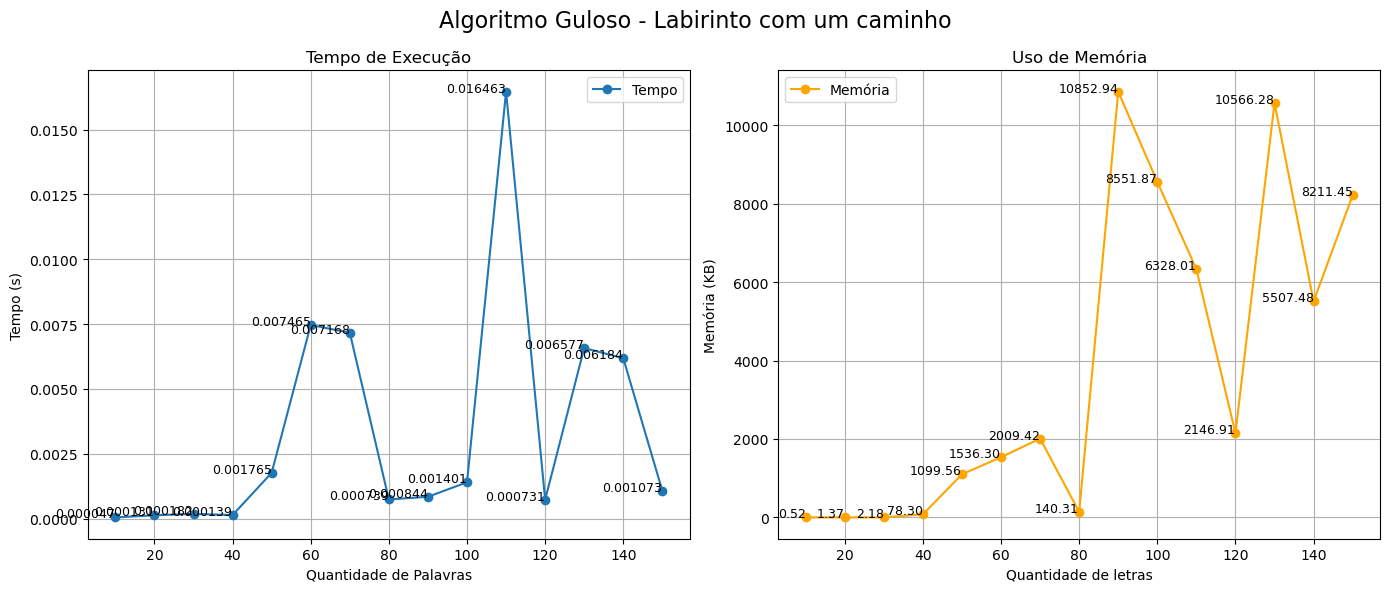

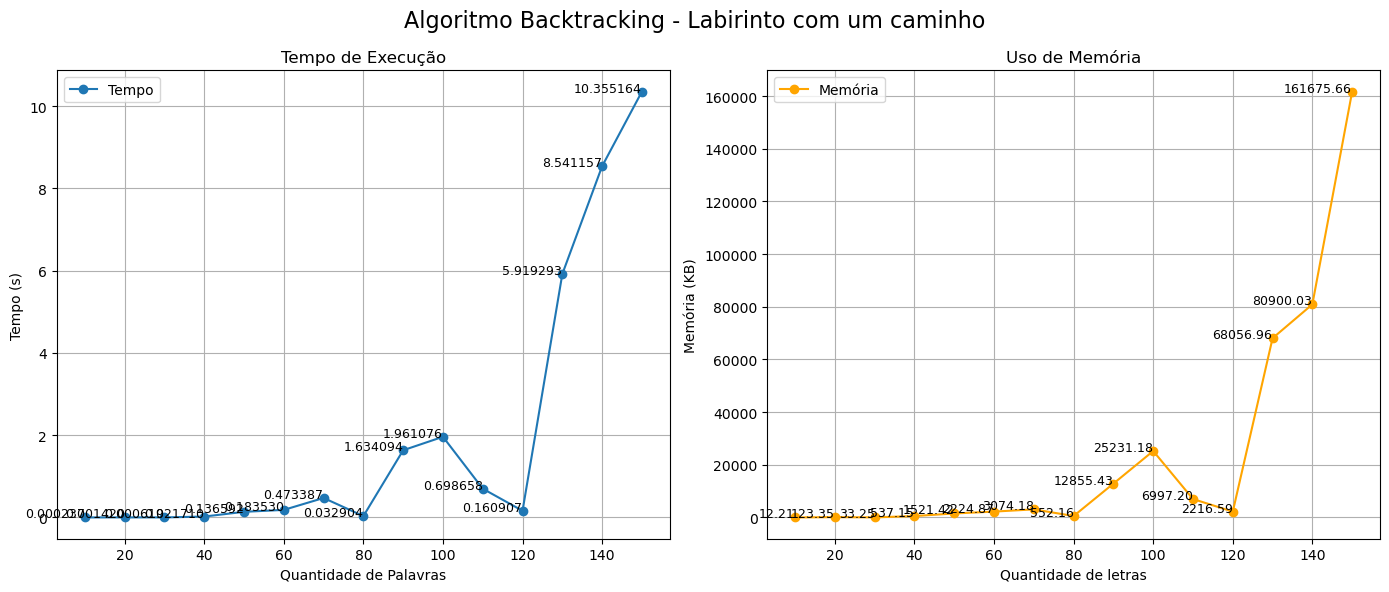

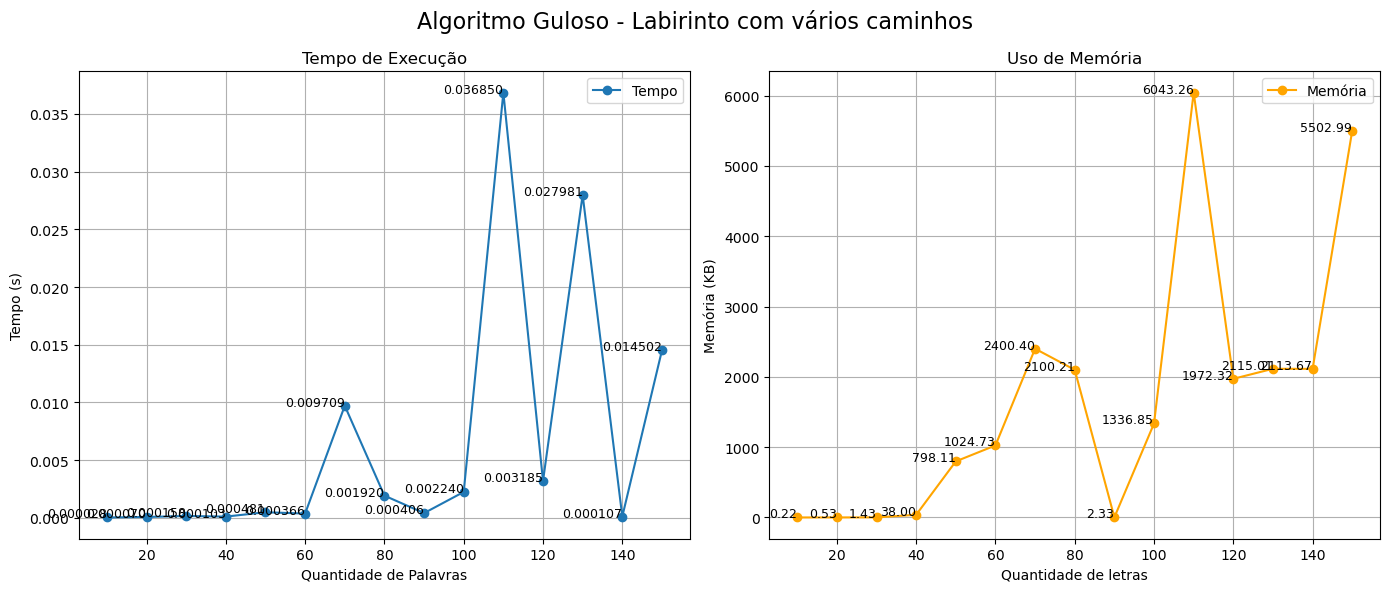

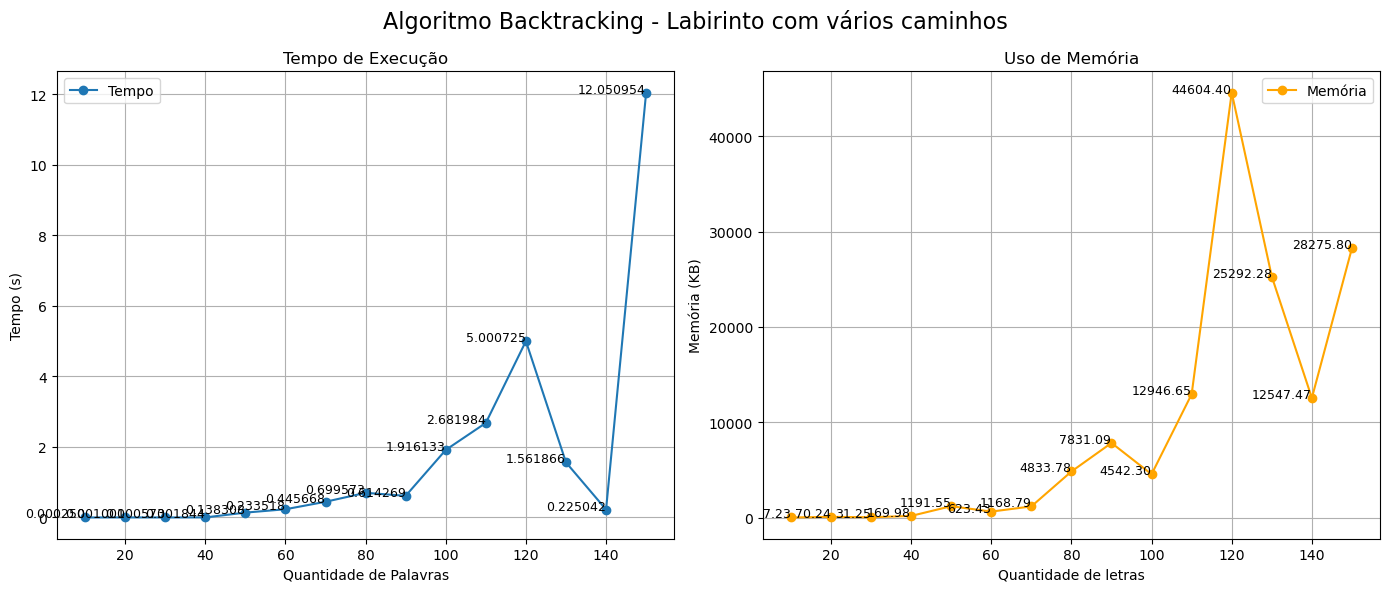

In [15]:
gerar_graficos(dados_algoritmo_guloso_only, "Algoritmo Guloso - Labirinto com um caminho")
gerar_graficos(dados_algoritmo_backtracking_only, "Algoritmo Backtracking - Labirinto com um caminho")
gerar_graficos(dados_algoritmo_guloso_mult, "Algoritmo Guloso - Labirinto com vários caminhos")
gerar_graficos(dados_algoritmo_backtracking_mult, "Algoritmo Backtracking - Labirinto com vários caminhos")

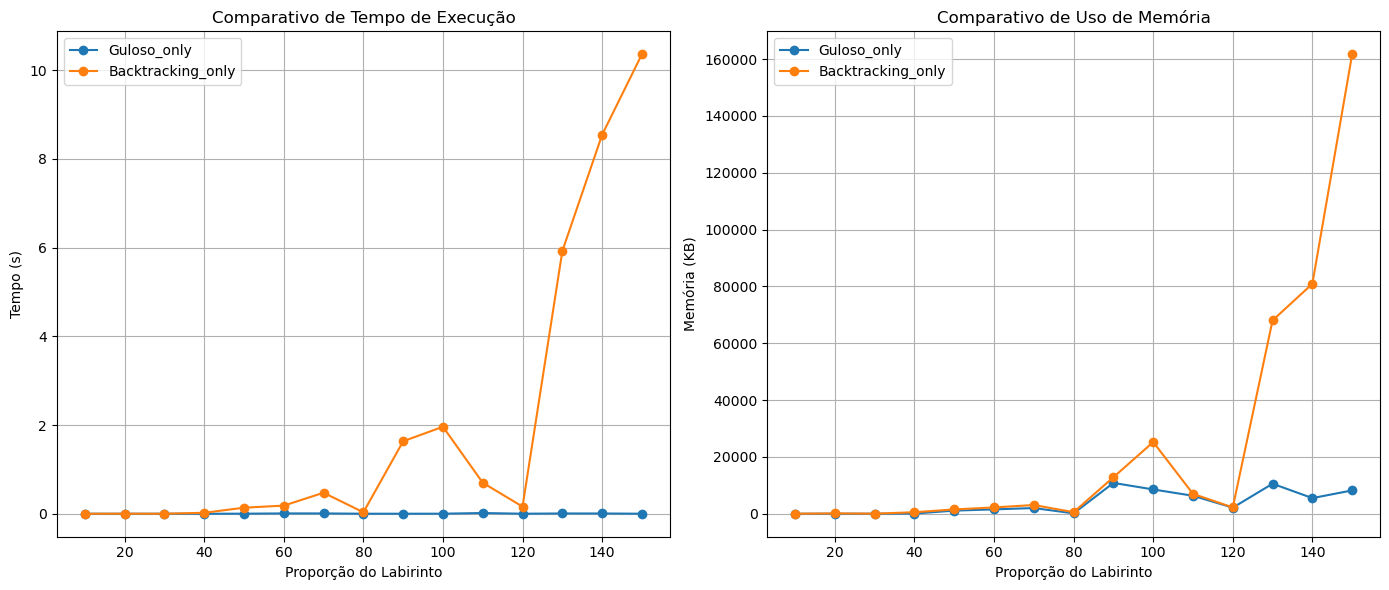

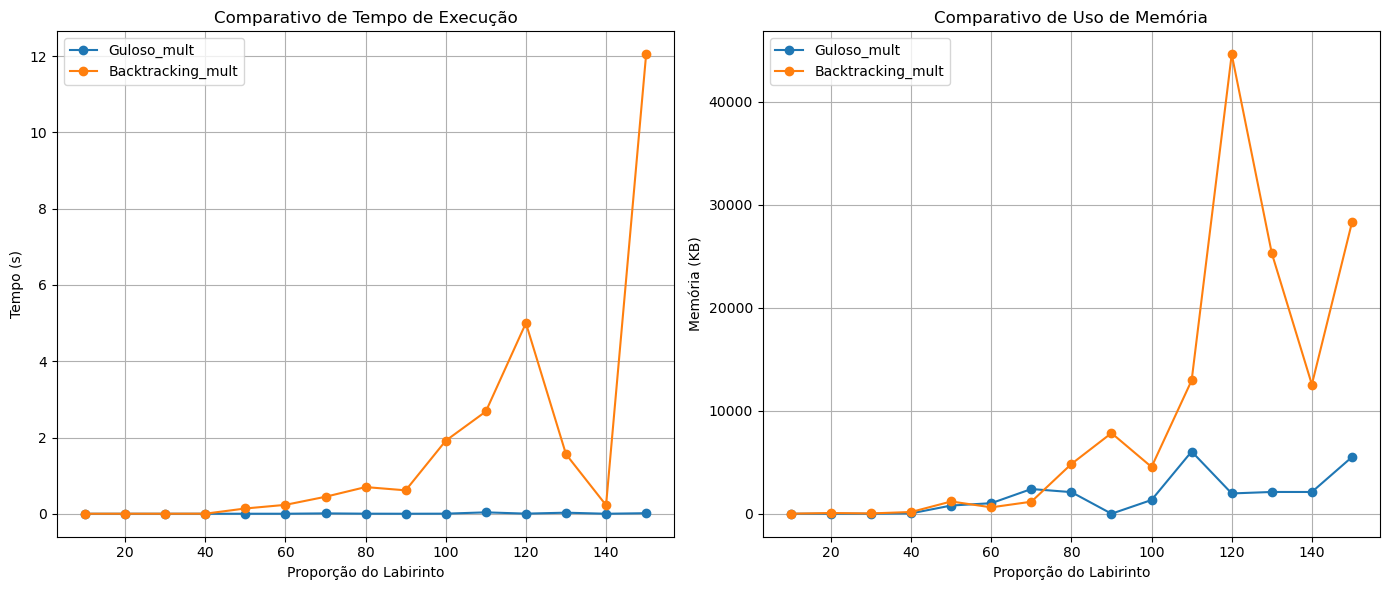

In [18]:
gerar_graficos_comparativos(dados_algoritmo_guloso_only, dados_algoritmo_backtracking_only, label1="Guloso_only", label2="Backtracking_only")
gerar_graficos_comparativos(dados_algoritmo_guloso_mult, dados_algoritmo_backtracking_mult, label1="Guloso_mult", label2="Backtracking_mult")